In [ ]:
from IPython.display import Image
Image(url='https://coleridgeinitiative.org/wp-content/uploads/2021/02/rich-context.png', width=900)

### The objective of the competition

- выявить упоминания наборов данных в научных публикациях.
 
Ваши прогнозы будут представлять собой короткие выдержки из публикаций, которые, кажется, содержат набор данных. Прогнозы, которые более точно соответствуют точным словам, используемым для идентификации набора данных в публикации, получат более высокий балл.

### Data Description

Публикации предоставляются в формате JSON, разбитые на разделы с названиями разделов.

Цель этого конкурса - **не просто сопоставить известные строки наборов данных, но и обобщить их на наборы данных, которые ранее не использовались с использованием НЛП и статистических методов**. Определенный процент публикаций общедоступных наборов тестов взят из обучающего набора - не все наборы данных были идентифицированы в процессе обучения, поэтому эти неопознанные наборы данных использовались как часть общедоступных тестовых меток. Они должны служить руководством для сложной задачи маркировки частного набора тестов.

Обратите внимание, что скрытый набор тестов содержит примерно ~ 8000 публикаций, что во много раз превышает размер общедоступного набора тестов. Соответственно планируйте время вычислений.

### Evaluated


Представленные материалы оцениваются по шкале FBeta на основе Жаккара между предсказанными текстами и текстами, содержащими правдивую информацию, с Beta = 0,5 (микро-оценка F0,5). Множественные прогнозы в отправляемом файле обозначены вертикальной чертой (|).

Ниже приведен справочный код Python для оценки Жаккарда:
```Python
def jaccard (str1, str2):
    а = набор (str1.lower (). split ())
    b = установить (str2.lower (). split ())
    c = a. пересечение (b)
    return float (len (c)) / (len (a) + len (b) - len (c))

```
Обратите внимание, что ВСЕ тексты достоверных данных были очищены для целей сопоставления с использованием следующего кода:

```Python
def clean_text (txt):
    return re.sub ('[^ A-Za-z0-9] +', '', str (txt) .lower ())

```
Для каждого набора прогнозов публикации оценка Жаккара на основе токенов рассчитывается для каждой потенциальной пары прогноз / достоверность. Прогноз с наивысшим баллом для данной базовой истины совпадает с этой базовой истиной.

Прогнозируемые строки для каждой публикации сортируются в алфавитном порядке и обрабатываются в указанном порядке. Любые результативные ничьи разрешаются на основе такого рода.
Любые совпадающие прогнозы, в которых оценка Жаккара соответствует пороговому значению 0,5 или превышает его, считаются истинно положительными (TP), остальные - ложноположительными (FP).

In [ ]:
import pandas as pd
import numpy as np
import os, glob

from tqdm import tqdm
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

PATH = '/content/drive/MyDrive/Coleridge_Initiative/input'

In [ ]:
# %load_ext google.colab.data_table
# %unload_ext google.colab.data_table

In [ ]:
df = pd.read_csv(os.path.join(PATH, 'train.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19661 entries, 0 to 19660
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             19661 non-null  object
 1   pub_title      19661 non-null  object
 2   dataset_title  19661 non-null  object
 3   dataset_label  19661 non-null  object
 4   cleaned_label  19661 non-null  object
dtypes: object(5)
memory usage: 768.1+ KB


id - идентификатор публикации - обратите внимание, что для некоторых обучающих документов есть несколько строк, указывающих на несколько упомянутых наборов данных

pub_title - название публикации (небольшое количество публикаций имеют такое же название)

dataset_title - заголовок набора данных, который упоминается в публикации

dataset_label - часть текста, обозначающая набор данных

cleaned_label - метка_данных, переданная через функцию clean_text со страницы оценки

In [ ]:
df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


In [ ]:
for col in df.columns:
    print(col, len(df[col].unique()))

Id 14316
pub_title 14271
dataset_title 45
dataset_label 130
cleaned_label 130


In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
df.groupby(['dataset_title'])['cleaned_label'].value_counts()

dataset_title                                                                                cleaned_label                                                                                                                   
Advanced National Seismic System (ANSS) Comprehensive Catalog (ComCat)                       anss comprehensive catalog                                                                                                            15
                                                                                             anss comprehensive earthquake catalog                                                                                                  7
                                                                                             advanced national seismic system anss comprehensive catalog comcat                                                                     6
                                                                                        

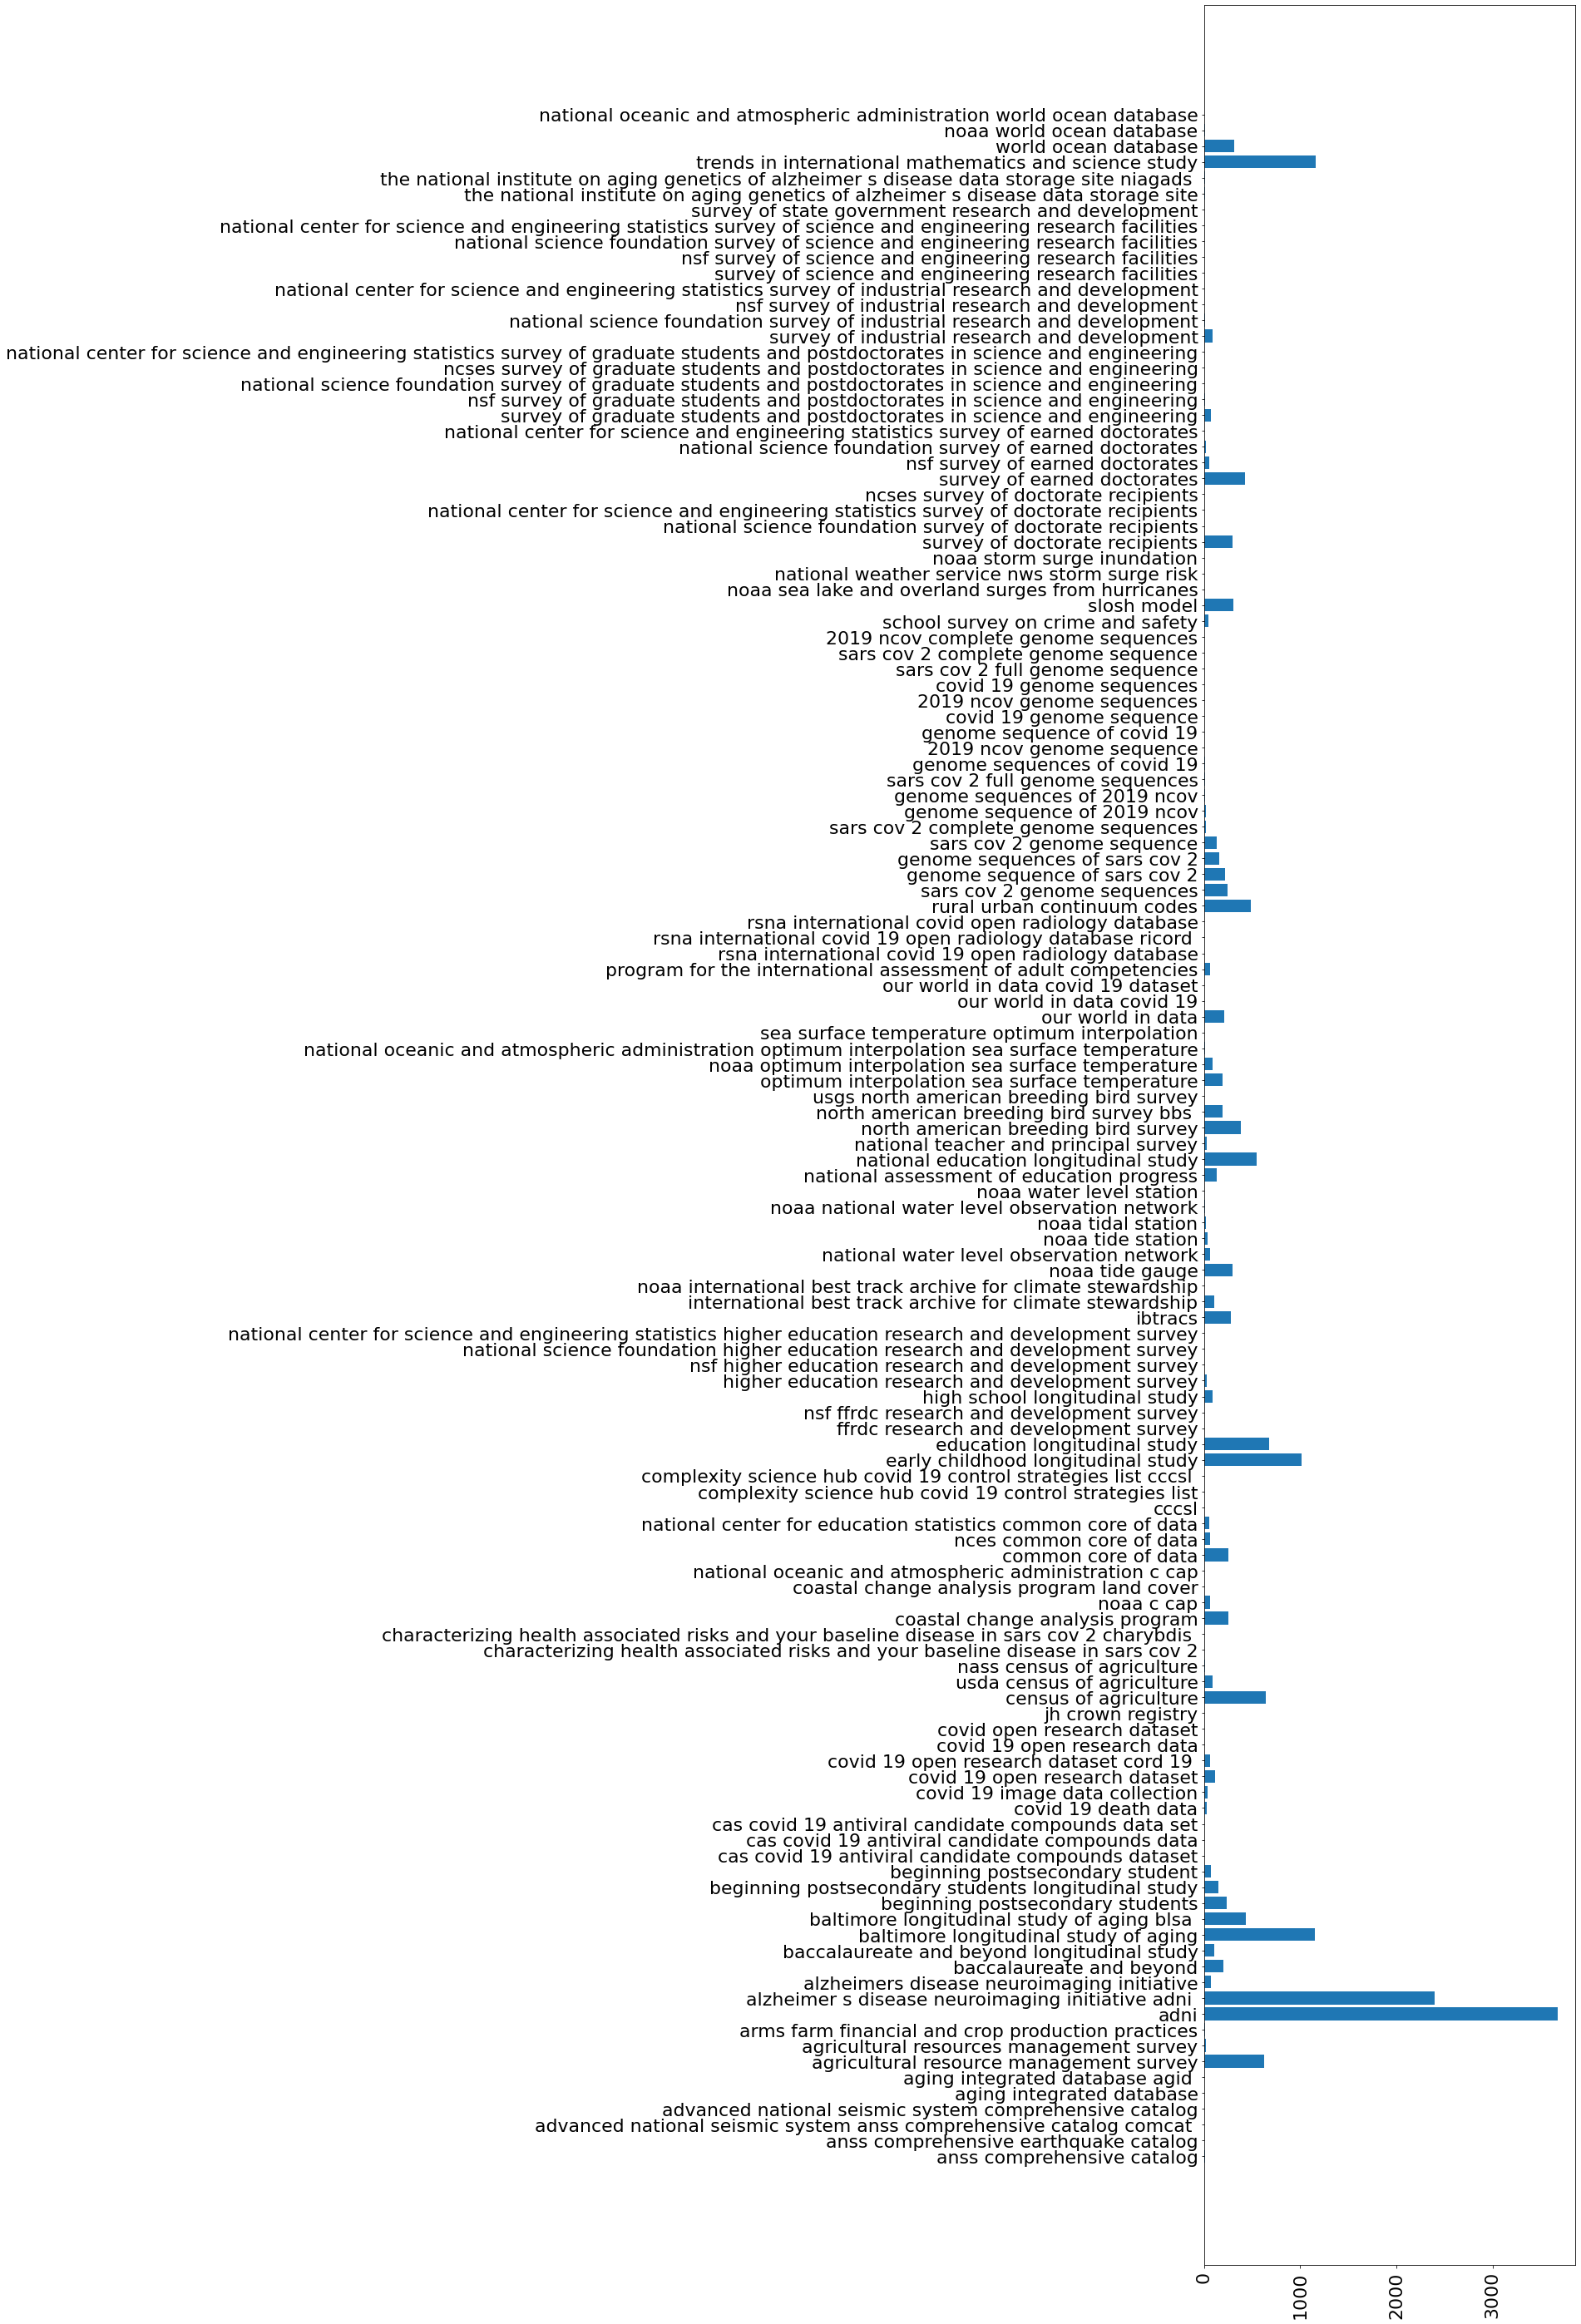

In [ ]:
df_count_dt_by_cl = df.groupby(['dataset_title'])['cleaned_label'].value_counts()
df_series = df_count_dt_by_cl.droplevel(0)#.to_frame().reset_index()
df_series = df_series.to_frame()
df_series.columns = ['count']
df_series = df_series.reset_index()

plt.figure(figsize= (8, 50))
plt.barh(df_series.cleaned_label, df_series['count'])
plt.xticks(rotation=90)
plt.tick_params(axis='both', which='major', labelsize=22)

Пример:
- paub title
```
The Impact of Dual Enrollment on College Degree Attainment: Do Low-SES Students Benefit?
```
- dataset title
```
National Education Longitudinal Study
```

- например возьмем dataset title is 'NOAA Tide Gauge'
    - pub_title (415) и они тоже могут повторяться
    ```
    Planning for the impact of sea-level rise on US national parks
    An examination of the June 2013 East Coast meteotsunami captured by NOAA observing systems
    A tsunami forecast model for Hilo, Hawaii 
    NOAA’s national water level observation network (NWLON) 
    ```
    - dataset label

    ```
    NOAA Tide Gauge                                  299
    National Water Level Observation Network          62
    NOAA tide station                                 35
    NOAA tidal station                                25
    NOAA National Water Level Observation Network     14
    NOAA water level station                           6 
    ```
    - cleaned label
    
    ```
    noaa tide gauge                                  299
    national water level observation network          62
    noaa tide station                                 35
    noaa tidal station                                25
    noaa national water level observation network     14
    noaa water level station                           6

    ```




In [ ]:
df.cleaned_label.value_counts()

adni                                                                                                                                3673
alzheimer s disease neuroimaging initiative adni                                                                                    2400
trends in international mathematics and science study                                                                               1163
baltimore longitudinal study of aging                                                                                               1156
early childhood longitudinal study                                                                                                  1011
education longitudinal study                                                                                                         676
census of agriculture                                                                                                                643
agricultural resource management survey  

### Wordcloud visual

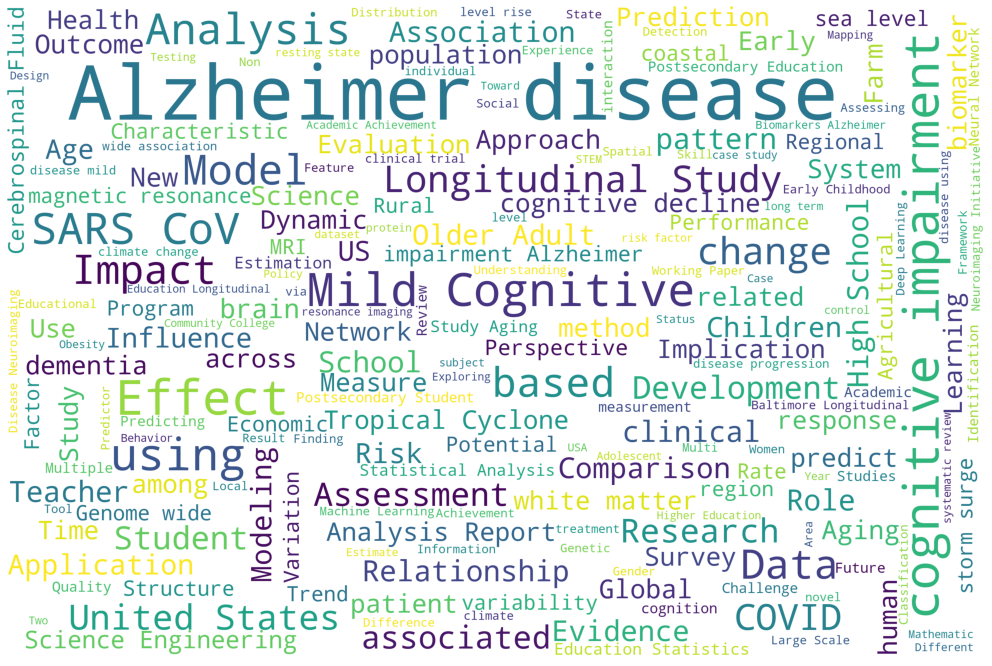

In [ ]:
 """
 1        2     3    4         5         6        7               8      9      10   11             12
 The	Impact	of	Dual	Enrollment	on	College	Degree	Attainment:	Do	Low-SES	Students	Benefit?
 
 .stack()

 ['The',
 'Impact',
 'of',
 'Dual',
 'Enrollment',
 'on',
 'College',
 'Degree',
 'Attainment:',
 'Do',
 'Low-SES',
 'Students',
 'Benefit?'
 ...
 
 len - 253863
 """
words_in_title = list(df.pub_title.str.split(expand = True).stack())
wordcloud = WordCloud(stopwords = STOPWORDS,
                      background_color = "white",
                      width = 3000,
                      height = 2000
                     ).generate(' '.join(words_in_title))
plt.figure(1, figsize = (18, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Json

In [ ]:
# /content/drive/MyDrive/Coleridge_Initiative/input/train

list_train_json = glob.glob(os.path.join(PATH, 'train', '*.json'))
list_test_json = glob.glob(os.path.join(PATH, 'test', '*.json'))

In [ ]:
test_tmp = []
train_tmp = []
for path in tqdm(list_test_json):
    data = pd.read_json(path)
    pb_id = path.split('/')[-1][:-5]
    data.insert(0, 'pb_id', pb_id)
    test_tmp.append(data)

for path in tqdm(list_train_json):
    data = pd.read_json(path)
    pb_id = path.split('/')[-1][:-5]
    data.insert(0, 'pb_id', pb_id)
    train_tmp.append(data)

df_train = pd.concat(train_tmp) # 100%|██████████| 14316/14316 [1:36:44<00:00,  2.47it/s]
df_test = pd.concat(test_tmp)

df_train.to_csv(os.path.join(PATH,'data_tarin.csv'), index = False)
df_test.to_csv(os.path.join(PATH,'data_test.csv'), index = False)

### Try submission

In [ ]:
def clean_text(txt: str)-> str:
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

sub = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))
titles = [tit.lower() for tit in (set(df.dataset_title) | set(df.dataset_label.values))]

In [ ]:
df_test[df_test.pb_id == '2100032a-7c33-4bff-97ef-690822c43466']

,pb_id,section_title,text
0,2100032a-7c33-4bff-97ef-690822c43466,Abstract,Cognitive deficits and reduced educational ach...
1,2100032a-7c33-4bff-97ef-690822c43466,Introduction,A general cognitive ability factor (also terme...
2,2100032a-7c33-4bff-97ef-690822c43466,Methods and Materials,COGENT is an international GWAS collaboration ...
3,2100032a-7c33-4bff-97ef-690822c43466,2011) Plink was used to analyze datasets compr...,", and GCTA used to analyze five datasets in wh..."
4,2100032a-7c33-4bff-97ef-690822c43466,Results,
5,2100032a-7c33-4bff-97ef-690822c43466,COGENT Analysis,"Using the approach described above, the two SN..."
6,2100032a-7c33-4bff-97ef-690822c43466,SSGAC Meta-Analysis,The SSGAC reanalyzed their GWAS data utilizing...
7,2100032a-7c33-4bff-97ef-690822c43466,CHARGE Meta-Analysis,A GWAS of general cognitive function that incl...
8,2100032a-7c33-4bff-97ef-690822c43466,Conclusions,The current study identified a significant ass...
9,2100032a-7c33-4bff-97ef-690822c43466,Supplementary Material,Refer to Web version on PubMed Central for sup...


In [ ]:
df_test[df_test.pb_id == '2100032a-7c33-4bff-97ef-690822c43466'].text.str.cat(sep = '\n').lower()

'cognitive deficits and reduced educational achievement are common in psychiatric illness; understanding the genetic basis of cognitive and educational deficits may be informative about the etiology of psychiatric disorders. a recent, large genomewide association study (gwas) reported a genome-wide significant locus for years of education, which subsequently demonstrated association to general cognitive ability ("g") in overlapping cohorts. the current study was designed to test whether gwas hits for educational attainment are involved in general cognitive ability in an independent, large-scale collection of cohorts. using cohorts in the cognitive genomics consortium (cogent; up to 20,495 healthy individuals), we examined the relationship between g and variants associated with educational attainment. we next conducted meta-analyses with 24,189 individuals with neurocognitive data from the educational attainment studies, and then with 53,188 largely independent individuals from a recent

In [ ]:
label = []
txt = df_test[df_test.pb_id == '2100032a-7c33-4bff-97ef-690822c43466']\
            .text.str.cat(sep = '\n').lower()
for tit in titles:
    if tit in txt:
        label.append(clean_text(tit))
'|'.join(label)

'alzheimer s disease neuroimaging initiative adni|adni'

### [Мера Жаккара](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%96%D0%B0%D0%BA%D0%BA%D0%B0%D1%80%D0%B0)
- (коэффициент флористической общности, фр. coefficient de communaute, нем. Gemeinschaftskoeffizient) — бинарная мера сходства, предложенная Полем Жаккаром в 1901 году.
$${K_{J}={\frac {c}{a+b-c}}}$$
где а — количество видов на первой пробной площадке,
 b — количество видов на второй пробной площадке,
 с — количество видов, общих для 1-й и 2-й площадок. 

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

jaccard('alzheimer s disease neuroimaging initiative adni', 'adni')

0.16666666666666666

### First submission, score = 0.7

In [ ]:
def filter_jacob(arg: list)-> str:  
       
    if len(arg) > 1: 
        perm = permutations(range(len(arg)))
        tmp_w = []
        tmp_s = []
        for i in perm:
            tmp_w.append(arg[i[0]]+ '|' +arg[i[1]])
            tmp_s.append(jaccard(arg[i[0]], arg[i[1]]))
        out = tmp_w[np.argmax(tmp_s)]      
    else:
        out = arg[0]
    return out

In [ ]:
for id_ in sub.Id.values:
    txt = df_test[df_test.pb_id == id_].text.str.cat(sep = '\n').lower()
    label = []
    for tit in titles:
        if tit in txt:
            label.append(clean_text(tit))    
    sub.loc[sub.Id == id_,'PredictionString'] = '|'.join(label)
sub

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,alzheimer s disease neuroimaging initiative ad...
1,2f392438-e215-4169-bebf-21ac4ff253e1,trends in international mathematics and scienc...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,noaa storm surge inundation|sea lake and overl...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes


### Test idea, **issue** not work kernel with submit run more 10 hours ends with error

In [ ]:
from itertools import permutations 

In [ ]:
for id_ in sub.Id.values:
    txt = df_test[df_test.pb_id == id_].text.str.cat(sep = '\n').lower()
    label = []
    for tit in titles:
        if tit in txt:
            label.append(clean_text(tit))    
    txt = filter_jacob(label)
    print(txt)
    sub.loc[sub.Id == id_,'PredictionString'] = txt
sub

### Links what need too learn

[List Of Kaggle NLP Competitions & solutions](https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data/discussion/228227)

[Visual Guide to Using BERT & other](http://jalammar.github.io/) is best understand how work


[NER](https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data/discussion/228376)
list ner competition and resurses to read

Распознавание именованных сущностей (NER) (также известное как идентификация (именованных) сущностей, разбиение сущностей на части и извлечение сущностей) - это подзадача извлечения информации, которая направлена ​​на поиск и классификацию именованных сущностей, упомянутых в неструктурированном тексте, по заранее определенным категориям, таким как человек имена, организации, местоположения, медицинские коды, выражения времени, количества, денежные значения, проценты и т.

[transformers](https://github.com/huggingface/transformers) lib

[sentence-transformers](https://github.com/UKPLab/sentence-transformers) lib

[Examples](https://huggingface.co/transformers/examples.html#glue) more code

[The Transformer from “Attention is All You Need” HARVARD](http://nlp.seas.harvard.edu/2018/04/03/attention.html) more code

In [ ]:
https://www.youtube.com/watch?v=rBCqOTEfxvg
https://www.kaggle.com/jamessorrell/spacy-ner-preprocessing
https://www.kaggle.com/robin26091991/topic-modelling-with-top2vec-show-us-the-data

### PS feedback organinzators


В тесте огромное количество ярлыков, которые вообще не упоминаются в train. Таким образом, задача состоит не столько в сопоставлении строк, сколько в создании решения НЛП для обобщения проблемы «могу ли я идентифицировать наборы данных, упомянутые в этом документе».

Пересечений нет